<font style='color:red'>CH5. LSTM/GRU</font>
- 5만개 영화 감상평(독립변수) -> 부정/긍정(종속변수)

## 1. 패키지

In [15]:

import numpy as np
from keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Dropout, GRU

from sklearn.metrics import confusion_matrix, f1_score, precision_score,recall_score

## 2. 하이퍼 파라미터 설정(이 파라미터를 바꾸면 정확도나 학습 속도에 차이남)

In [18]:
MY_WORDS = 10000 # imdb 데이터의 단어수
MY_LENGTH = 80   # 영화평 단어수 80개만 독립변수
MY_EMBED = 32    # Embedding layer의 결과 차원
MY_HIDDEN = 64   # LSTM의 유닛수

MY_EPOCH = 10    # 학습 수
MY_BATCH = 200   # batch_size (fit이 매번 데이터를 가져오는 값)

## 3. 데티어불러오기

In [19]:

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MY_WORDS)

In [20]:
print('학습용 독립변수 모양 :',x_train.shape)
print('학습용 종속변수 모양 :',y_train.shape)
print('학습셋 샘플 :',len(x_train[0]))

학습용 독립변수 모양 : (25000,)
학습용 종속변수 모양 : (25000,)
학습셋 샘플 : 218


In [21]:
# 긍정/부정 갯수
print('학습셋의 긍정 갯수 :', y_train.sum())
print('테스트셋의 긍정 갯수 :', y_test.sum())

학습셋의 긍정 갯수 : 12500
테스트셋의 긍정 갯수 : 12500


## 4. 문자단어 -> 정수

In [22]:
word_to_id = imdb.get_word_index() # {'word':id}
print(word_to_id['movie'])
print(word_to_id['film'])
print(word_to_id['sonja'])
print(word_to_id['a'])
print(word_to_id['the'])
id_to_word = {}
for word, value in word_to_id.items():
    id_to_word[value] = word
print(id_to_word[1])
# 정수 -> 문자 단어

17
19
16816
3
1
the


In [23]:
msg = 'What a wonderful movie'
msg = msg.lower().split()
# 1: 리뷰시작을 알리는 숫자, 2: 문자가 짤려서 잘못읽어옴, 3: padding 처리
data = [1] + [word_to_id.get(m,-1)+3 for m in msg]
print('원 후기 내용 :', msg)
print('encoded된 data :' ,data)
print('추정된 data :', ' '.join([id_to_word.get(d-3, '???') for d in data]))

원 후기 내용 : ['what', 'a', 'wonderful', 'movie']
encoded된 data : [1, 51, 6, 389, 20]
추정된 data : ??? what a wonderful movie


## 5. 숫자영화평 -> 자연어 영화평 return 함수

In [24]:
def decoding(review_num):
    decoded = [id_to_word.get(num-3, '???') for num in review_num]
    return ' '.join(decoded)

In [25]:
print(decoding(x_train[0]),'\n', y_train[0])

??? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ??? is an amazing actor and now the same being director ??? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ??? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ??? to the two little boy's that played the ??? of norman and paul they were just brilliant children are often left out of the ??? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done

In [26]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

## 6. 영화평 (독립변수)의 길이

In [29]:
def show_length(x_train):
    print('첫 20개 영화평 길이')
    print([len(x_data) for x_data in x_train[:20]])

In [30]:
print('제일 긴 영화평 단어 길이 :', max(len(x_data) for x_data in x_train))
print('제일 짧 영화평 단어 길이 :', min(len(x_data) for x_data in x_train))
print('영화평 단어 길이 중위수 :',np.median([len(x_data) for x_data in x_train]))

제일 긴 영화평 단어 길이 : 2494
제일 짧 영화평 단어 길이 : 11
영화평 단어 길이 중위수 : 178.0


## 7. 모든 영화평 길이를 동일하게(80)

In [31]:
X_train = pad_sequences(x_train, padding='pre',truncating='pre',maxlen=MY_LENGTH)
X_test = pad_sequences(x_test, padding='pre',truncating='pre',maxlen=MY_LENGTH)
show_length(X_train), show_length(X_test)

첫 20개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
첫 20개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]


(None, None)

## 8. 최종 데이터 shape 확인

In [32]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 80), (25000,), (25000, 80), (25000,))

## 9. 모델 생성

In [33]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS,     # 10000
                    output_dim=MY_EMBED,    # 32
                    input_length=MY_LENGTH))# 80
# RNN : 입력 단어의 길이 수가 너무 길면 파라미터 업데이트 안 됨
# 개선모델1 . LSTM 개선모델2. GRU
model.add(Dropout(0.4))
model.add(GRU(units=MY_HIDDEN,
               input_shape=(MY_LENGTH,MY_EMBED)))

model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 32)            320000    
                                                                 
 dropout_1 (Dropout)         (None, 80, 32)            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                18816     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 338,881
Trainable params: 338,881
Non-trainable params: 0
_________________________________________________________________


## 10. 학습환경 설정 및 학습하기

In [34]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

hist = model.fit(X_train, y_train, epochs=5, batch_size=MY_BATCH, validation_split=0.2)

Epoch 1/5
100/100 [==============================] - 10s 88ms/step - loss: 0.5830 - acc: 0.6650 - val_loss: 0.4019 - val_acc: 0.8230
Epoch 2/5
100/100 [==============================] - 8s 85ms/step - loss: 0.3369 - acc: 0.8536 - val_loss: 0.3624 - val_acc: 0.8428
Epoch 3/5
100/100 [==============================] - 8s 83ms/step - loss: 0.2719 - acc: 0.8924 - val_loss: 0.3644 - val_acc: 0.8370
Epoch 4/5
100/100 [==============================] - 8s 83ms/step - loss: 0.2322 - acc: 0.9083 - val_loss: 0.3821 - val_acc: 0.8352
Epoch 5/5
100/100 [==============================] - 8s 83ms/step - loss: 0.2054 - acc: 0.9221 - val_loss: 0.4163 - val_acc: 0.8278


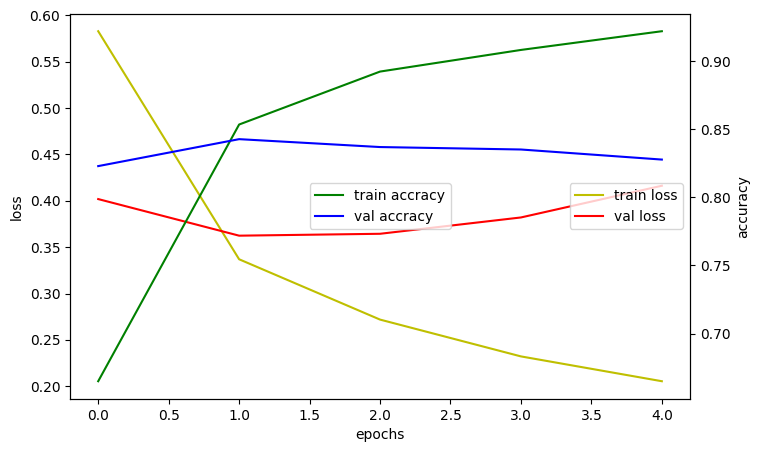

In [35]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(8,5))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax =loss_ax.twinx()
acc_ax.plot(hist.history['acc'], 'g', label='train accracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val accracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc = 'center right')
acc_ax.legend(loc = 'center')


# 11. 모델 평가하기

In [122]:
# 혼동행렬, recall, precision을 위한 yhat
y_hat = (model.predict(X_test)>0.5).astype(np.int16)
print(y_hat.reshape(-1))

782/782 [==============================] - 10s 13ms/step
[0 1 1 ... 0 0 1]


In [124]:
# 혼동행렬
confusion_matrix(y_test, y_hat)

array([[10246,  2254],
       [ 2579,  9921]], dtype=int64)

In [ ]:
# recall (실제 True인 것 중 True로 예측한 비율)
recall_score(y_test, y_hat)


0.79368

In [126]:
# precisioin(True로 예측한 것 중 실제값을 False로 예측한 비율)
precision_score(y_test, y_hat)

0.8148665297741273

In [3]:
model = load_model('data/영화감정평가.h5')

# 11.모델 사용

In [36]:
import re
review = 'The movie was so boring that I slept the whole time watching it'.lower()
review = re.sub('[^a-zA-Z\'\s]', ' ', review)
print('영화평(특수문자 제외) :',review)
review = review.split()
review = [1] + [word_to_id.get(word,-1)+3 for word in review]

영화평(특수문자 제외) : the movie was so boring that i slept the whole time watching it


In [37]:
input_data = pad_sequences([review], padding='pre',truncating='pre',maxlen=MY_LENGTH)

In [ ]:
result = model.predict(input_data > 0.5).astype('int8').reshape(-1)[0]
result

1/1 [==============================] - 0s 361ms/step


0